# Model Template for amliNet :)

In [54]:
import os
import numpy as np
import pandas as pd
import math
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Flatten, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

## Global Variables

In [46]:
outcomes = ['No Finding',
            'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']
pathologies = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
            'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
            'Support Devices']

#Edit these global variables
PATH = '/Volumes/GBackup/Data/CheXpertDataset'
target = 'Cardiomegaly'

image_size = 256
train_batch_size = 32
val_batch_size = 32
test_batch_size = 234

steps_per_epoch = 32
num_epochs = 1

threshold = 0.5

## Preprocessing

In [3]:
def edit_urls(url):
    ''' a function to edit the urls to the correct path using a global PATH variable declared earlier
    '''
    pieces = url.split('/')
    newurl = ''

      #removing the previous path 'CheXpert-v1.0-small' and including the PATH
    for i, piece in enumerate(pieces):
        if i > 0:
            newurl+= '/' + piece
        elif i == 0:
            newurl += PATH

    return newurl

def clean_data(df):
    '''
    Edits the urls, fills the 'maybes' with yes and the nulls with no,
    removes outlier ages (age 0 patients), removes 'unknown gender' patients,
    collects which type of image it is
    '''
    df['Path'] = df['Path'].apply(edit_urls)
    df[outcomes] = df[outcomes].fillna(0)
    df[outcomes] = df[outcomes].replace(-1,1)
    df = df[df['Age'] > 1]
    df = df[(df['Sex'] == 'Male') | (df['Sex'] == 'Female')]
    df['Image Type'] = df['AP/PA'].fillna('Lateral')
    return df


In [21]:
train_df = clean_data( pd.read_csv(PATH + '/train.csv') )
test_df = clean_data( pd.read_csv(PATH + '/valid.csv'))


#can chose a subset here
train_df = train_df.sample(frac=0.005)

#for keras, make the target a string
train_df[target] = train_df[target].apply(str)
test_df[target] = test_df[target].apply(str)

print('test set:', test_df.shape)
print('training set:', train_df.shape)
train_df.head(3)

test set: (234, 20)
training set: (1117, 20)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Image Type
40672,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,36,Frontal,PA,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,PA
72752,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,52,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,AP
132438,/Volumes/GBackup/Data/CheXpertDataset/train/pa...,Male,48,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,PA


## Prepare the Model

In [20]:
datagen = ImageDataGenerator(
   rescale = 1./255,
   validation_split = 0.2
)

train_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=target,
   color_mode='grayscale', # images will be converted to have 1 color channel
   target_size=(image_size, image_size), #The dimensions to which all images found will be resized
   class_mode='binary', # Mode for yielding the targets 1D numpy array of binary labels,if class_mode is "binary" it must include the given y_col column with class values as strings.
   batch_size=train_batch_size,
   subset = "training"
   #shuffle: whether to shuffle the data (default: True)
)

validation_generator = datagen.flow_from_dataframe(
   train_df,
   x_col='Path',
   y_col=target,
   target_size=(image_size, image_size),
   color_mode='grayscale',
   class_mode='binary',
   batch_size=val_batch_size,
   subset = "validation"
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='Path',
    y_col=target,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=test_batch_size,
    shuffle = False #just in case
)

Found 894 validated image filenames belonging to 2 classes.
Found 223 validated image filenames belonging to 2 classes.
Found 234 validated image filenames belonging to 2 classes.


### Edit your model here

In [29]:
model = tf.keras.Sequential([
   tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(image_size,image_size,1)),
   tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=tf.train.AdamOptimizer(),
  metrics=['accuracy'])

## Run the model

### Train the model

In [30]:
# uses some global variables
history = model.fit_generator(train_generator,
                   steps_per_epoch = 4, #can automatically chose the best steps per epoch
                   epochs = num_epochs,
                   validation_data=validation_generator
                  )

4/4 [==============================] - 32s 8s/step - loss: 10.5341 - acc: 0.6406 - val_loss: 1.6449 - val_acc: 0.8610


### Make Predictions

In [ ]:
predictions = model.predict_generator(test_generator)
print(f'made {len(predictions)} predictions')

# This checks the row that is related to 'being sick' (... hopefully)
probability_sick = predictions.T[1]
print(probability_sick[0:10].round())
actual_labels = test_generator[0][1]
print(actual_labels[0:10])

made 234 predictions
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Do metrics

In [49]:
def get_confusion_matrix(predictions, actuals, threshold):
    """
    Returns a confusion matrix whose rows correspond to predicted outputs and
       whose columns correspond to actual outputs.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    threshold: float, value above which predictions are classified as positive,
       below which predictions are classified as negative.
    """
    bool_predictions = (predictions > threshold)
    bool_actuals = (actuals > threshold)

    return confusion_matrix(bool_predictions, bool_actuals)

[[166  68]
 [  0   0]]


In [65]:
def get_metrics(predictions, actuals, threshold):
    """
    Prints all metrics associated with the model output.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    threshold: float, value above which predictions are classified as positive,
       below which predictions are classified as negative.
    """
    TP, FP, FN, TN = get_confusion_matrix(predictions, actuals, threshold).ravel()

    trues = TP + TN
    wrongs = FP + FN
    sensitivity = TP / (TP + FN) # This is also recall
    specificity = TN / (TN + FP)
    precision = TP / (TP +FP)
    accuracy = (TP + TN) / (TP + TN + FP +FN)
    F1 = 2 / ((1 / precision) + (1 / sensitivity))

    print("Correct Predictions:   {}".format(trues))
    print("Incorrect Predictions: {}".format(wrongs))
    print()
    print("Sensitivity/recall:    {}".format(sensitivity))
    print("Specificity:           {}".format(specificity))
    print("Precision:             {}".format(precision))
    print("Accuracy:              {}".format(accuracy))
    print("F1 score:              {}".format(F1))
    
    return

In [59]:
def get_roc_curve(predictions, actuals):
    """
    Plots the ROC curve and associated AUC of the model output.

    predictions: 1D numpy array.
    actuals: 1D numpy array.
    """
    FPR, TPR, thresholds = roc_curve(actuals, predictions)
    AUC = roc_auc_score(actuals, predictions)

    plt.plot(FPR, TPR, "b-")
    plt.plot([0, 1], [0, 1], "r--")
    plt.title("Receiver Operating Characteristic \n AUC: {}".format(AUC))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel("Sensitivity")
    plt.xlabel("1 - Specificity")
    plt.show()
    
    return

In [60]:
def get_precision_recall_curve(predictions, actuals):
    """
    Plots the precision-recall curve and associated AUC of the model output.

    predictions: 2D numpy array.
    actuals: 1D numpy array.
    """
    precisions, recalls, thresholds = precision_recall_curve(actuals, predictions)
    AUC = auc(recalls, precisions)

    plt.plot(recalls, precisions, "b-")
    plt.plot([0, 1], [1, 0], "r--")
    plt.title("Precision-Recall Curve \n AUC: {}".format(AUC))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.ylabel("Recall")
    plt.xlabel("Precision")
    plt.show()
    return


In [76]:
def display_conf_mat(predictions, actuals, threshold):
    '''
    Displays the confusion matrix
    '''
    cm = get_confusion_matrix(predictions, actuals, threshold)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap=plt.cm.Blues,fmt='g') #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()
    return

## Run the Metrics

Correct Predictions:   166
Incorrect Predictions: 68

Sensitivity/recall:    1.0
Specificity:           0.0
Precision:             0.7094017094017094
Accuracy:              0.7094017094017094
F1 score:              0.8300000000000001


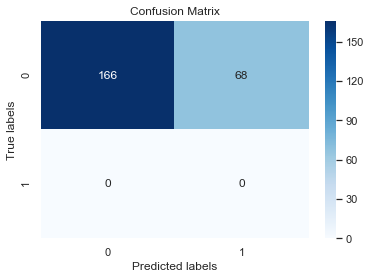

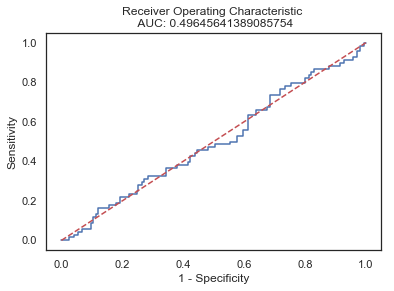

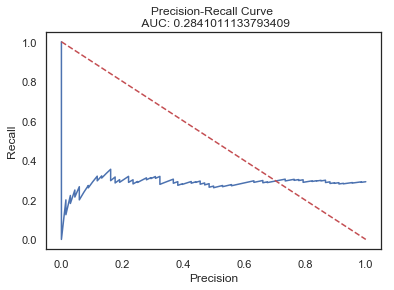

In [79]:
get_metrics(probability_sick, actual_labels, threshold)
display_conf_mat(probability_sick, actual_labels, threshold)
get_roc_curve(probability_sick, actual_labels)
get_precision_recall_curve(probability_sick, actual_labels)